In [1]:
import os
from pytube import YouTube
from pydub import AudioSegment
import requests
from dotenv import load_dotenv

import yt_dlp
import os

load_dotenv()

True

In [2]:
SARVAM_KEY = os.getenv('SARVAM_KEY')
youtube_link = "https://www.youtube.com/watch?v=PM1mT4AYyCc"  # Replace with your YouTube video URL


# Download Youtube vid's audio

In [3]:
def download_youtube_audio(url, output_path='downloads', audio_format='mp3'):
    """
    Downloads audio from a YouTube video.

    Parameters:
    - url (str): The URL of the YouTube video.
    - output_path (str): The directory where the audio will be saved.
    - audio_format (str): The desired audio format (e.g., 'mp3', 'm4a').

    Returns:
    - str: The path to the downloaded audio file.
    """
    # Ensure the output directory exists
    os.makedirs(output_path, exist_ok=True)
    
    # Set up yt_dlp options
    ydl_opts = {
        'format': 'bestaudio/best',  # Select the best available audio quality
        'outtmpl': os.path.join(output_path, '%(title)s.%(ext)s'),  # Output template
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',  # Extract audio using FFmpeg
            'preferredcodec': audio_format,  # Desired audio format
            'preferredquality': '192',  # Audio quality
        }],
        'quiet': False,  # Set to True to suppress output
        'noplaylist': True,  # Only download single video, not playlist
    }

    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        try:
            # Extract information and download
            info_dict = ydl.extract_info(url, download=True)
            
            # Prepare the filename
            filename = ydl.prepare_filename(info_dict)
            base, _ = os.path.splitext(filename)
            audio_file = f"{base}.{audio_format}"
            
            print(f"Audio downloaded successfully: {audio_file}")
            return audio_file
        except yt_dlp.utils.DownloadError as e:
            print(f"Error downloading audio: {e}")
            return None

In [4]:
downloaded_audio = download_youtube_audio(youtube_link, output_path='audio_files', audio_format='mp3')
if downloaded_audio:
    print(f"Downloaded audio file path: {downloaded_audio}")
else:
    print("Failed to download audio.")


[youtube] Extracting URL: https://www.youtube.com/watch?v=PM1mT4AYyCc
[youtube] PM1mT4AYyCc: Downloading webpage
[youtube] PM1mT4AYyCc: Downloading ios player API JSON
[youtube] PM1mT4AYyCc: Downloading web creator player API JSON
[youtube] PM1mT4AYyCc: Downloading player e38bb6de
[youtube] PM1mT4AYyCc: Downloading m3u8 information
[info] PM1mT4AYyCc: Downloading 1 format(s): 251
[download] Destination: audio_files/Nani's special & powerful characters ｜ nani ｜ vithin-cine.webm
[download] 100% of    3.48MiB in 00:00:00 at 14.87MiB/s  
[ExtractAudio] Destination: audio_files/Nani's special & powerful characters ｜ nani ｜ vithin-cine.mp3
Deleting original file audio_files/Nani's special & powerful characters ｜ nani ｜ vithin-cine.webm (pass -k to keep)
Audio downloaded successfully: audio_files/Nani's special & powerful characters ｜ nani ｜ vithin-cine.mp3
Downloaded audio file path: audio_files/Nani's special & powerful characters ｜ nani ｜ vithin-cine.mp3


# Extract first few seconds

In [8]:
from pydub import AudioSegment

def extract_first_15_seconds(input_audio_path, output_audio_path='extracted_audio', duration_seconds=15, audio_format='mp3'):
    """
    Extracts the first 15 seconds of an audio file.

    Parameters:
    - input_audio_path (str): Path to the input audio file.
    - output_audio_path (str): Directory where the extracted audio will be saved.
    - duration_seconds (int): Duration to extract in seconds. Defaults to 15.
    - audio_format (str): Format of the output audio file. Defaults to 'mp3'.

    Returns:
    - str: Path to the extracted audio file.
    """
    # Ensure the output directory exists
    os.makedirs(output_audio_path, exist_ok=True)
    
    try:
        # Load the audio file
        audio = AudioSegment.from_file(input_audio_path)
        
        # Extract the first 'duration_seconds' seconds
        extracted_audio = audio[:duration_seconds * 1000]  # pydub works in milliseconds
        
        # Prepare the output file path
        base = os.path.basename(input_audio_path)
        name, _ = os.path.splitext(base)
        output_file = os.path.join(output_audio_path, f"{name}_first_{duration_seconds}s.{audio_format}")
        
        # Export the extracted audio
        extracted_audio.export(output_file, format=audio_format)
        
        print(f"Extracted first {duration_seconds} seconds: {output_file}")
        return output_file
    except Exception as e:
        print(f"Error extracting audio: {e}")
        return None


In [9]:
if downloaded_audio:
    extracted_audio = extract_first_15_seconds(
        downloaded_audio,
        output_audio_path='extracted_audio',
        duration_seconds=15,
        audio_format='mp3'
    )
    if extracted_audio:
        print(f"Extracted audio file path: {extracted_audio}")
    else:
        print("Failed to extract audio.")
else:
    print("Download step failed. Cannot extract audio.")

Extracted first 15 seconds: extracted_audio/Nani's special & powerful characters ｜ nani ｜ vithin-cine_first_15s.mp3
Extracted audio file path: extracted_audio/Nani's special & powerful characters ｜ nani ｜ vithin-cine_first_15s.mp3


# Send request to sarvam

In [13]:
import mimetypes

def send_to_sarvam_api(audio_file_path, api_key, prompt=None, model='saaras:v1'):
    """
    Sends an audio file to the Sarvam Speech To Text Translate API for transcription.

    Parameters:
    - audio_file_path (str): Path to the audio file to be transcribed.
    - api_key (str): Your Sarvam API subscription key.
    - prompt (str, optional): Prompt to assist the transcription.
    - model (str, optional): Model to be used. Defaults to 'saaras:v1'.

    Returns:
    - dict: The API response containing the transcript and language_code.
    """
    url = "https://api.sarvam.ai/speech-to-text-translate"

    headers = {
        'api-subscription-key': api_key
    }

    # Determine MIME type based on file extension
    mime_type, _ = mimetypes.guess_type(audio_file_path)
    if mime_type not in ['audio/mpeg', 'audio/wave', 'audio/wav', 'audio/x-wav']:
        print(f"Unsupported audio format: {mime_type}")
        return None

    with open(audio_file_path, 'rb') as f:
        files = {
            'file': (os.path.basename(audio_file_path), f, mime_type)
        }

        data = {
            'model': model
        }

        if prompt:
            data['prompt'] = prompt

        try:
            response = requests.post(url, headers=headers, files=files, data=data)
            response.raise_for_status()
            result = response.json()
            print("API Response:")
            print(result)
            return result
        except requests.exceptions.HTTPError as http_err:
            print(f"HTTP error occurred: {http_err} - {response.text}")
        except Exception as err:
            print(f"An error occurred: {err}")

    return None

In [14]:
if not SARVAM_KEY:
    print("Error: SARVAM_KEY environment variable not set.")
    exit(1)

    
if extracted_audio:
    # Step 3: Send to Sarvam API
    api_response = send_to_sarvam_api(
        extracted_audio,
        api_key=SARVAM_KEY,
        prompt='This is a telugu audio. Translate it to english',  # Optional: Add any prompt if needed
        model='saaras:v1'  # You can change the model if needed
    )
    
    if api_response:
        transcript = api_response.get('transcript', '')
        language_code = api_response.get('language_code', '')
        print(f"\nTranscript:\n{transcript}\n")
        print(f"Detected Language Code: {language_code}")
    else:
        print("API call failed.")


API Response:
{'transcript': "Why is she called a natural star? I am not motivating or inspiring you by telling my personal stories about Nani. It's a waste of time. I am talking about the characters Nani plays, from Ashtachamma to the recent movie Ante Sundarani.", 'language_code': 'te-IN'}

Transcript:
Why is she called a natural star? I am not motivating or inspiring you by telling my personal stories about Nani. It's a waste of time. I am talking about the characters Nani plays, from Ashtachamma to the recent movie Ante Sundarani.

Detected Language Code: te-IN


# Breaking into chunks of silence

In [23]:
from pydub import AudioSegment, silence
import os

def split_audio_on_silence(input_audio_path, output_dir='audio_chunks', 
                           min_silence_len=1000, silence_thresh=-40, 
                           keep_silence=500, max_chunk_duration=7000):
    """
    Splits audio into chunks based on silence and maximum duration.
    
    Parameters:
    - input_audio_path (str): Path to the input audio file.
    - output_dir (str): Directory to save the audio chunks.
    - min_silence_len (int): Minimum length of silence in ms.
    - silence_thresh (int): Silence threshold in dBFS.
    - keep_silence (int): Amount of silence to keep at the beginning and end of each chunk in ms.
    - max_chunk_duration (int): Maximum duration of each chunk in ms (e.g., 7000 ms for 7 seconds).
    
    Returns:
    - List of tuples: Each tuple contains (chunk_path, start_time, end_time)
    """
    os.makedirs(output_dir, exist_ok=True)
    audio = AudioSegment.from_file(input_audio_path)
    
    print("Splitting audio into chunks based on silence...")
    initial_chunks = silence.split_on_silence(
        audio,
        min_silence_len=min_silence_len,
        silence_thresh=silence_thresh,
        keep_silence=keep_silence
    )
    
    final_chunks = []
    current_time = 0  # in milliseconds
    
    for i, chunk in enumerate(initial_chunks):
        chunk_duration = len(chunk)
        start_time = current_time
        end_time = current_time + chunk_duration
        
        # If chunk is longer than max_chunk_duration, split it further
        if chunk_duration > max_chunk_duration:
            num_subchunks = chunk_duration // max_chunk_duration + 1
            subchunk_duration = chunk_duration / num_subchunks
            for j in range(num_subchunks):
                sub_start = j * subchunk_duration
                sub_end = (j + 1) * subchunk_duration
                subchunk = chunk[int(sub_start):int(sub_end)]
                
                subchunk_filename = f"chunk_{i+1}_{j+1}.mp3"
                subchunk_path = os.path.join(output_dir, subchunk_filename)
                subchunk.export(subchunk_path, format="mp3")
                
                sub_start_time = start_time + int(sub_start)
                sub_end_time = start_time + int(sub_end)
                
                final_chunks.append((subchunk_path, sub_start_time, sub_end_time))
                print(f"Created {subchunk_filename}: {sub_start_time/1000:.2f}s to {sub_end_time/1000:.2f}s")
                
            current_time += chunk_duration + keep_silence
        else:
            # Export the chunk as is
            chunk_filename = f"chunk_{i+1}.mp3"
            chunk_path = os.path.join(output_dir, chunk_filename)
            chunk.export(chunk_path, format="mp3")
            
            final_chunks.append((chunk_path, start_time, end_time))
            print(f"Created {chunk_filename}: {start_time/1000:.2f}s to {end_time/1000:.2f}s")
            
            # Update the current time
            current_time = end_time + keep_silence  # Adding kept silence to avoid overlap
    
    return final_chunks


In [24]:
if downloaded_audio:
    # Split the audio into chunks
    chunks = split_audio_on_silence(
        downloaded_audio,
        output_dir='audio_chunks',
        min_silence_len=1000,
        silence_thresh=-40,
        keep_silence=500
    )
else:
    print("Download step failed.")

Splitting audio into chunks based on silence...
Created chunk_1_1.mp3: 0.00s to 6.84s
Created chunk_1_2.mp3: 6.84s to 13.68s
Created chunk_1_3.mp3: 13.68s to 20.52s
Created chunk_1_4.mp3: 20.52s to 27.35s
Created chunk_1_5.mp3: 27.35s to 34.19s
Created chunk_1_6.mp3: 34.19s to 41.03s
Created chunk_1_7.mp3: 41.03s to 47.87s
Created chunk_1_8.mp3: 47.87s to 54.71s
Created chunk_1_9.mp3: 54.71s to 61.55s
Created chunk_1_10.mp3: 61.55s to 68.38s
Created chunk_1_11.mp3: 68.38s to 75.22s
Created chunk_1_12.mp3: 75.22s to 82.06s
Created chunk_1_13.mp3: 82.06s to 88.90s
Created chunk_1_14.mp3: 88.90s to 95.74s
Created chunk_1_15.mp3: 95.74s to 102.58s
Created chunk_1_16.mp3: 102.58s to 109.41s
Created chunk_1_17.mp3: 109.41s to 116.25s
Created chunk_1_18.mp3: 116.25s to 123.09s
Created chunk_1_19.mp3: 123.09s to 129.93s
Created chunk_1_20.mp3: 129.93s to 136.77s
Created chunk_1_21.mp3: 136.77s to 143.60s
Created chunk_2.mp3: 144.10s to 147.84s
Created chunk_3_1.mp3: 148.34s to 155.05s
Created 

# Modified sarvam func

In [25]:
def send_to_sarvam_api(audio_file_path, api_key, prompt=None, model='saaras:v1'):
    """
    Sends an audio file to the Sarvam Speech To Text Translate API for transcription.

    Parameters:
    - audio_file_path (str): Path to the audio file to be transcribed.
    - api_key (str): Your Sarvam API subscription key.
    - prompt (str, optional): Prompt to assist the transcription.
    - model (str, optional): Model to be used. Defaults to 'saaras:v1'.

    Returns:
    - dict: The API response containing the transcript and language_code.
    """
    url = "https://api.sarvam.ai/speech-to-text-translate"

    headers = {
        'api-subscription-key': api_key
    }

    # Determine MIME type based on file extension
    mime_type, _ = mimetypes.guess_type(audio_file_path)
    if mime_type not in ['audio/mpeg', 'audio/wave', 'audio/wav', 'audio/x-wav']:
        print(f"Unsupported audio format: {mime_type}")
        return None

    with open(audio_file_path, 'rb') as f:
        files = {
            'file': (os.path.basename(audio_file_path), f, mime_type)
        }

        data = {
            'model': model
        }

        if prompt:
            data['prompt'] = prompt

        try:
            response = requests.post(url, headers=headers, files=files, data=data)
            response.raise_for_status()
            result = response.json()
            print(f"Transcription successful for {os.path.basename(audio_file_path)}")
            return result
        except requests.exceptions.HTTPError as http_err:
            print(f"HTTP error occurred for {os.path.basename(audio_file_path)}: {http_err} - {response.text}")
        except Exception as err:
            print(f"An error occurred for {os.path.basename(audio_file_path)}: {err}")

    return None


# For each chunk, collect transcript from sarvam 

In [26]:
def process_chunks_and_collect_transcripts(chunks, api_key):
    """
    Processes each audio chunk and collects transcripts with timestamps.

    Parameters:
    - chunks (list): List of tuples containing (chunk_path, start_time, end_time).
    - api_key (str): Your Sarvam API subscription key.

    Returns:
    - List of dictionaries: Each dict contains 'start_time', 'end_time', and 'transcript'.
    """
    transcripts = []
    for chunk_path, start_ms, end_ms in chunks:
        print(f'Processing chunk: {chunk_path} from {start_ms/1000:.2f}s to {end_ms/1000:.2f}s')
        response = send_to_sarvam_api(chunk_path, api_key)
        if response and 'transcript' in response:
            transcript = response['transcript']
            transcripts.append({
                'start_time': start_ms,
                'end_time': end_ms,
                'transcript': transcript
            })
        else:
            transcripts.append({
                'start_time': start_ms,
                'end_time': end_ms,
                'transcript': '[Unintelligible]'
            })
    return transcripts


# Format time for format

In [27]:
def format_timestamp(ms):
    """
    Formats milliseconds to SRT timestamp format.

    Parameters:
    - ms (int): Time in milliseconds.

    Returns:
    - str: Formatted timestamp.
    """
    seconds, milliseconds = divmod(ms, 1000)
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    return f"{hours:02}:{minutes:02}:{seconds:02},{milliseconds:03}"

def create_srt_file(transcripts, output_file='subtitles.srt', max_chars=42):
    """
    Creates an SRT file from transcripts with timestamps, ensuring readability.

    Parameters:
    - transcripts (list): List of dictionaries containing 'start_time', 'end_time', and 'transcript'.
    - output_file (str): Path to save the SRT file.
    - max_chars (int): Maximum number of characters per subtitle line.

    Returns:
    - None
    """
    with open(output_file, 'w', encoding='utf-8') as f:
        subtitle_number = 1
        for entry in transcripts:
            start = format_timestamp(entry['start_time'])
            end = format_timestamp(entry['end_time'])
            text = entry['transcript'].replace('\n', ' ').strip()
            
            # Split text into multiple lines if it exceeds max_chars
            lines = []
            words = text.split()
            current_line = ""
            for word in words:
                if len(current_line) + len(word) + 1 <= max_chars:
                    if current_line:
                        current_line += ' '
                    current_line += word
                else:
                    lines.append(current_line)
                    current_line = word
            if current_line:
                lines.append(current_line)
            
            # Combine lines with newline characters
            formatted_text = '\n'.join(lines)
            
            # Write to SRT
            f.write(f"{subtitle_number}\n{start} --> {end}\n{formatted_text}\n\n")
            subtitle_number += 1
    print(f"SRT file created at {output_file}")



In [28]:
transcripts = process_chunks_and_collect_transcripts(chunks, SARVAM_KEY)

if not transcripts:
    print("No transcripts collected.")
    

create_srt_file(transcripts, output_file='subtitles.srt', max_chars=42)

Processing chunk: audio_chunks/chunk_1_1.mp3 from 0.00s to 6.84s
Transcription successful for chunk_1_1.mp3
Processing chunk: audio_chunks/chunk_1_2.mp3 from 6.84s to 13.68s
Transcription successful for chunk_1_2.mp3
Processing chunk: audio_chunks/chunk_1_3.mp3 from 13.68s to 20.52s
Transcription successful for chunk_1_3.mp3
Processing chunk: audio_chunks/chunk_1_4.mp3 from 20.52s to 27.35s
Transcription successful for chunk_1_4.mp3
Processing chunk: audio_chunks/chunk_1_5.mp3 from 27.35s to 34.19s
Transcription successful for chunk_1_5.mp3
Processing chunk: audio_chunks/chunk_1_6.mp3 from 34.19s to 41.03s
Transcription successful for chunk_1_6.mp3
Processing chunk: audio_chunks/chunk_1_7.mp3 from 41.03s to 47.87s
Transcription successful for chunk_1_7.mp3
Processing chunk: audio_chunks/chunk_1_8.mp3 from 47.87s to 54.71s
Transcription successful for chunk_1_8.mp3
Processing chunk: audio_chunks/chunk_1_9.mp3 from 54.71s to 61.55s
Transcription successful for chunk_1_9.mp3
Processing ch

In [3]:
import yt_dlp
import os
from pydub import AudioSegment
import requests
import mimetypes
import math
import logging
from tqdm import trange, tqdm
import shutil

In [38]:
video_format = 'mp4'
output_path = 'delete_me'
ydl_opts = {
        'format': f'bestvideo[ext={video_format}]+bestaudio[ext=m4a]/best[ext={video_format}]',
        'outtmpl': os.path.join(output_path, '%(title)s.%(ext)s'),
        'merge_output_format': video_format,
        'quiet': True,
        'no_warnings': True,
        'restrictfilenames': True,
    }

In [39]:
youtube_link = 'https://www.youtube.com/watch?v=bw0eox2JlpE'

In [47]:
info_dict.keys()

dict_keys(['id', 'title', 'formats', 'thumbnails', 'thumbnail', 'description', 'channel_id', 'channel_url', 'duration', 'view_count', 'average_rating', 'age_limit', 'webpage_url', 'categories', 'tags', 'playable_in_embed', 'live_status', 'release_timestamp', '_format_sort_fields', 'automatic_captions', 'subtitles', 'comment_count', 'chapters', 'heatmap', 'like_count', 'channel', 'channel_follower_count', 'channel_is_verified', 'uploader', 'uploader_id', 'uploader_url', 'upload_date', 'timestamp', 'availability', 'original_url', 'webpage_url_basename', 'webpage_url_domain', 'extractor', 'extractor_key', 'playlist', 'playlist_index', 'display_id', 'fulltitle', 'duration_string', 'release_year', 'is_live', 'was_live', 'requested_subtitles', '_has_drm', 'epoch', 'requested_downloads', 'requested_formats', 'format', 'format_id', 'ext', 'protocol', 'language', 'format_note', 'filesize_approx', 'tbr', 'width', 'height', 'resolution', 'fps', 'dynamic_range', 'vcodec', 'vbr', 'stretched_ratio',

In [ ]:
info_dict['2']

In [40]:
with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    info_dict = ydl.extract_info(youtube_link, download=True)
    video_title = info_dict.get('title', None)
    video_ext = info_dict.get('ext', None)
    video_filename = f"{video_title}.{video_ext}"
    video_path = os.path.join(output_path, video_filename)

In [48]:
ydl.prepare_filename(info_dict)


'delete_me/Maa_Nanna_Super_Hero_Teaser_Sudheer_Babu_Sayaji_Shinde_Sai_Chand_Abhilash_Kankara.mp4'

In [7]:
video_path

'delete_me/Maa Nanna Super Hero Teaser | Sudheer Babu | Sayaji Shinde | Sai Chand | Abhilash Kankara.mp4'

In [24]:
downloaded_video = 'delete_me/Maa Nanna Super Hero Teaser ｜ Sudheer Babu ｜ Sayaji Shinde ｜ Sai Chand ｜ Abhilash Kankara.mp4'

In [27]:
import unidecode

# Original filename with non-ASCII characters

# Use unidecode to convert non-ASCII characters to their ASCII equivalents
normalized_filename = unidecode.unidecode(downloaded_video)

# Optionally, you can also remove special characters like '|' if needed
cleaned_filename = normalized_filename.replace('|', '')

print(cleaned_filename)


delete_me/Maa Nanna Super Hero Teaser  Sudheer Babu  Sayaji Shinde  Sai Chand  Abhilash Kankara.mp4


In [28]:
video_path == cleaned_filename

False

In [ ]:
print(downloaded_video)

delete_me/Maa Nanna Super Hero Teaser ｜ Sudheer Babu ｜ Sayaji Shinde ｜ Sai Chand ｜ Abhilash Kankara.mp4


In [ ]:
import difflib


differ = difflib.ndiff(downloaded_video, video_path)
diff = ''.join(differ)

print(diff)

  d  e  l  e  t  e  _  m  e  /  M  a  a     N  a  n  n  a     S  u  p  e  r     H  e  r  o     T  e  a  s  e  r   - ｜+ |     S  u  d  h  e  e  r     B  a  b  u   - ｜+ |     S  a  y  a  j  i     S  h  i  n  d  e   - ｜+ |     S  a  i     C  h  a  n  d   - ｜+ |     A  b  h  i  l  a  s  h     K  a  n  k  a  r  a  .  m  p  4


In [ ]:
# convert downloaded_video string to ascii numbers
downloaded_video_ascii = [ord(char) for char in downloaded_video]
video_path_ascii = [ord(char) for char in video_path]


In [34]:
for a,b in zip(video_path, downloaded_video):
    if a != b:
        print(a, b)
        print(ord(a), ord(b))
        

| ｜
124 65372
| ｜
124 65372
| ｜
124 65372
| ｜
124 65372


In [35]:
import unicodedata
normalized_video = unicodedata.normalize('NFKC', downloaded_video)

In [36]:
normalized_video == video_path

True

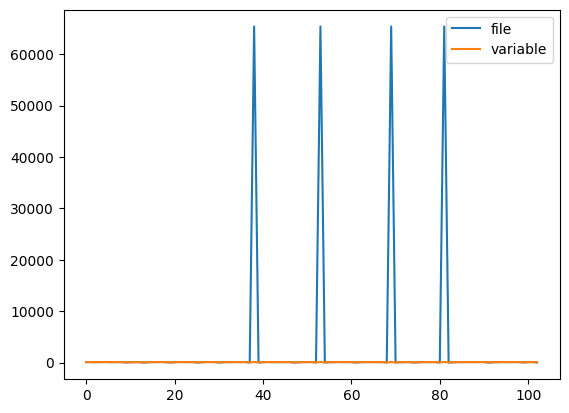

In [ ]:
import matplotlib.pyplot as plt

plt.plot(downloaded_video_ascii, label='file')
plt.plot(video_path_ascii, label='variable');
plt.legend();

In [ ]:
os.path.exists(downloaded_video), os.path.exists(video_path)

(True, False)